# Transmission Line Analysis and Quarter-Wave Transformer

This notebook demonstrates transmission line theory and impedance matching using a quarter-wave transformer. We'll analyze:

1. **Direct impedance mismatch** between a 50Ω source and 100Ω load
2. **Quarter-wave transformer matching** to improve the impedance match
3. **Standing wave patterns** formed by incident and reflected waves

## Theory Overview

When there's an impedance mismatch between source and load, some power is reflected back, creating standing waves. A quarter-wave transformer can provide impedance matching by using a transmission line section with characteristic impedance $Z_{0,qw} = \sqrt{Z_{source} \cdot Z_L}$.

The reflection coefficient is given by: $\Gamma = \frac{Z_{in} - Z_{source}}{Z_{in} + Z_{source}}$

Key metrics:
- **Return Loss (RL)**: $RL = -20\log_{10}|\Gamma|$ (dB)
- **VSWR**: $VSWR = \frac{1 + |\Gamma|}{1 - |\Gamma|}$

=== At design freq f0 = 2.45 GHz ===
Direct connect:
  Zin = (100+0j)
  |Γ|  = 0.33333333333333337
  RL   = 9.542425094393248 dB
  VSWR = 2.0000000000000004

With λ/4 transformer:
  Zin = (50.00009686664554-0.06959398604383765j)
  |Γ|  = 0.0006959396919066709
  RL   = 63.148567868908074 dB
  VSWR = 1.001392848722524


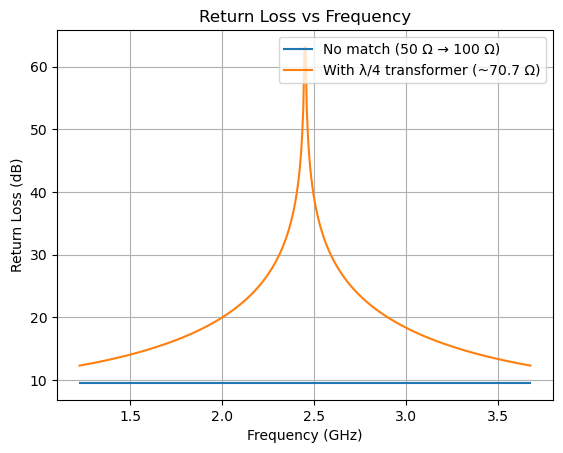

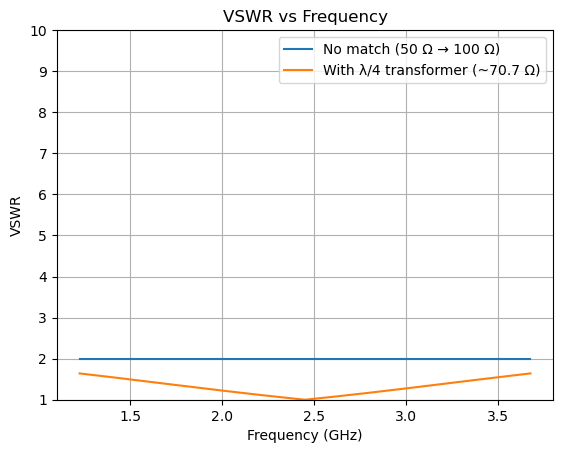

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# Parameters
# -----------------------
c = 3e8                     # speed of light in vacuum (m/s)
vp = 0.66 * c               # phase velocity in the line (typical coax with VF~0.66)
Z_source = 50.0             # source / system impedance
ZL = 100.0                  # actual load (antenna etc.)
Z0_line = 50.0              # normal transmission line impedance
f0 = 2.45e9                 # design frequency (e.g. 2.45 GHz ISM band)

# quarter-wave transformer design impedance
Z0_qw = np.sqrt(Z_source * ZL)  # = ~70.7 ohms

# frequency sweep around f0
freqs = np.linspace(0.5*f0, 1.5*f0, 400)   # sweep 0.5x to 1.5x center freq
beta = 2 * np.pi * freqs / vp              # β = 2π/λ, λ = vp/f

# electrical length of the λ/4 section AT f0
lambda0 = vp / f0
l_qw = lambda0 / 4.0   # physical length of the quarter-wave transformer section

# helper: input impedance looking into a transmission line section
def zin_transmission_line(Z0, ZL, beta, l):
    """
    Z0 : characteristic impedance of the line
    ZL : load impedance at the end of the line
    beta: array of propagation constants (rad/m) for each freq
    l : physical length of the line (m)
    returns: array of Zin for each freq
    """
    j = 1j
    bl = beta * l
    num = ZL + j * Z0 * np.tan(bl)
    den = Z0 + j * ZL * np.tan(bl)
    return Z0 * (num / den)

# Case A: direct connection (50 Ω line straight into 100 Ω load)
# Seen by the source: just ZL (ignoring any long extra line)
Zin_direct = ZL * np.ones_like(freqs, dtype=complex)

# Case B: add λ/4 transformer between 50 Ω system and 100 Ω load
# First: input impedance of the λ/4 transformer section terminated by ZL
Zin_qw_section = zin_transmission_line(Z0_qw, ZL, beta, l_qw)

# The source is 50 Ω feeding Zin_qw_section directly
# (i.e. assume negligible extra length of 50 Ω feed line)
Zin_match = Zin_qw_section

# reflection coefficient at the source for each case
Gamma_direct = (Zin_direct - Z_source) / (Zin_direct + Z_source)
Gamma_match  = (Zin_match  - Z_source) / (Zin_match  + Z_source)

# metrics
def return_loss_db(Gamma):
    # RL = -20 log10 |Gamma|
    mag = np.abs(Gamma)
    # avoid log of 0
    mag = np.maximum(mag, 1e-12)
    return -20*np.log10(mag)

def vswr(Gamma):
    g = np.abs(Gamma)
    return (1+g)/(1-g)

RL_direct = return_loss_db(Gamma_direct)
RL_match  = return_loss_db(Gamma_match)

VSWR_direct = vswr(Gamma_direct)
VSWR_match  = vswr(Gamma_match)

# -----------------------
# Plot Return Loss
# -----------------------
plt.figure()
plt.plot(freqs/1e9, RL_direct, label='No match (50 Ω → 100 Ω)')
plt.plot(freqs/1e9, RL_match,  label='With λ/4 transformer (~70.7 Ω)')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Return Loss (dB)')
plt.title('Return Loss vs Frequency')
plt.legend()
plt.grid(True)

# -----------------------
# Plot VSWR
# -----------------------
plt.figure()
plt.plot(freqs/1e9, VSWR_direct, label='No match (50 Ω → 100 Ω)')
plt.plot(freqs/1e9, VSWR_match,  label='With λ/4 transformer (~70.7 Ω)')
plt.xlabel('Frequency (GHz)')
plt.ylabel('VSWR')
plt.title('VSWR vs Frequency')
plt.ylim(1, 10)  # clip for readability
plt.legend()
plt.grid(True)

# -----------------------
# Print some representative numbers at f0
# -----------------------
idx0 = np.argmin(np.abs(freqs - f0))

print("=== At design freq f0 = %.2f GHz ===" % (f0/1e9))
print("Direct connect:")
print("  Zin =", Zin_direct[idx0])
print("  |Γ|  =", np.abs(Gamma_direct[idx0]))
print("  RL   =", RL_direct[idx0], "dB")
print("  VSWR =", VSWR_direct[idx0])

print("\nWith λ/4 transformer:")
print("  Zin =", Zin_match[idx0])
print("  |Γ|  =", np.abs(Gamma_match[idx0]))
print("  RL   =", RL_match[idx0], "dB")
print("  VSWR =", VSWR_match[idx0])

plt.show()

## Part 1: Quarter-Wave Transformer Analysis

### Parameters Setup
We define the system parameters for a typical RF application at 2.45 GHz (ISM band):
- **Source impedance**: 50Ω (standard for RF systems)
- **Load impedance**: 100Ω (mismatched antenna)
- **Quarter-wave transformer impedance**: $\sqrt{50 \times 100} \approx 70.7$Ω
- **Phase velocity**: 0.66c (typical for coaxial cable)

### Results Analysis

The code calculates and plots:

1. **Return Loss vs Frequency**: Shows how much power is reflected back
   - Higher return loss (more negative dB) = better matching
   - At the design frequency (2.45 GHz), the quarter-wave transformer should provide significant improvement

2. **VSWR vs Frequency**: Voltage Standing Wave Ratio
   - VSWR = 1 indicates perfect match (no reflections)
   - VSWR > 2 typically indicates poor matching

3. **Numerical Results**: Exact values at the design frequency for comparison

The quarter-wave transformer works perfectly at the design frequency but has limited bandwidth - performance degrades as frequency moves away from 2.45 GHz.

## Part 2: Standing Wave Visualization

### Theory of Standing Waves

When an incident wave encounters a reflection at a load mismatch, the incident and reflected waves interfere to create a **standing wave pattern**. This is described by:

$$V(x) = V_+ e^{-j\beta x} + \Gamma V_+ e^{+j\beta x}$$

Where:
- $V_+$ = incident wave amplitude
- $\Gamma$ = reflection coefficient  
- $\beta = 2\pi/\lambda$ = propagation constant
- $x$ = position along the transmission line

### Key Concepts:
- **$|\Gamma| = 0$**: No reflection → traveling wave (no standing wave)
- **$|\Gamma| = 1$**: Total reflection → pure standing wave with nulls
- **$0 < |\Gamma| < 1$**: Partial reflection → standing wave with finite minima

The visualization below shows how incident and reflected waves combine to form the resultant standing wave pattern.

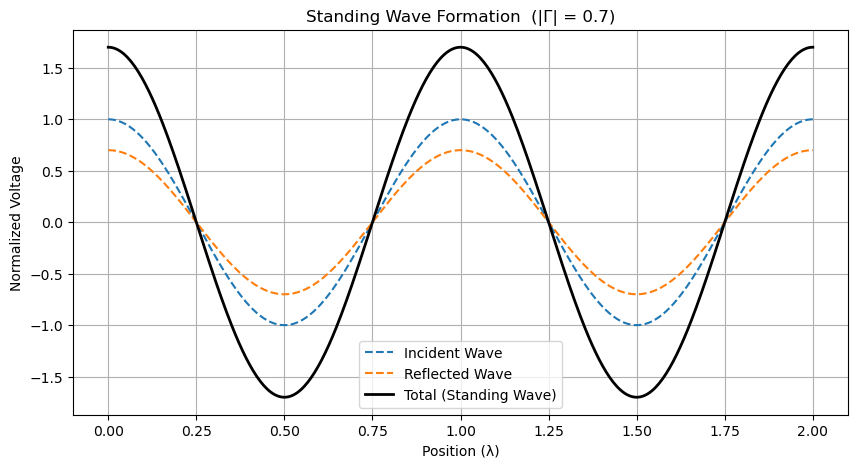

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Parameters
# --------------------------
Z0 = 50              # characteristic impedance
Gamma_mag = 0.7      # reflection coefficient magnitude (try 0, 0.3, 0.7, 1)
Gamma_phase = 0      # phase of reflection (radians)
Gamma = Gamma_mag * np.exp(1j * Gamma_phase)

# Wave parameters
lambda0 = 1.0        # normalize wavelength = 1 unit
beta = 2 * np.pi / lambda0
V0_plus = 1.0        # incident wave amplitude
x = np.linspace(0, 2*lambda0, 400)  # position along line (2 wavelengths)
t = 0                # fixed time snapshot (you can try animating later)

# --------------------------
# Calculate voltage waves
# --------------------------
# Incident wave: V+ e^{-jβx}
V_incident = V0_plus * np.exp(-1j * beta * x)
# Reflected wave: Γ V+ e^{+jβx}
V_reflected = Gamma * V0_plus * np.exp(1j * beta * x)
# Total voltage (superposition)
V_total = V_incident + V_reflected

# Take real part (voltage vs position)
V_incident_real = np.real(V_incident)
V_reflected_real = np.real(V_reflected)
V_total_real = np.real(V_total)

# --------------------------
# Plot
# --------------------------
plt.figure(figsize=(10,5))
plt.plot(x/lambda0, V_incident_real, '--', label='Incident Wave')
plt.plot(x/lambda0, V_reflected_real, '--', label='Reflected Wave')
plt.plot(x/lambda0, V_total_real, 'k', linewidth=2, label='Total (Standing Wave)')
plt.xlabel('Position (λ)')
plt.ylabel('Normalized Voltage')
plt.title(f'Standing Wave Formation  (|Γ| = {Gamma_mag})')
plt.legend()
plt.grid(True)
plt.show()

### Standing Wave Analysis Results

The plot above demonstrates:

1. **Blue dashed line**: Incident wave traveling in the +x direction
2. **Orange dashed line**: Reflected wave traveling in the -x direction  
3. **Black solid line**: Total voltage = superposition of incident + reflected

**Observations:**
- With $|\Gamma| = 0.7$, we see a strong standing wave pattern
- Maximum voltage occurs where incident and reflected waves add constructively
- Minimum voltage occurs where they add destructively
- The pattern repeats every $\lambda/2$ along the transmission line

**Try different values:**
- Change `Gamma_mag` to 0, 0.3, 0.7, or 1.0 to see different reflection scenarios
- Modify `Gamma_phase` to shift the phase of the reflection

## Part 3: Transmission Line Losses

### Theory of Lossy Transmission Lines

Real transmission lines have losses due to:
1. **Conductor losses** (resistance of the conductors) - increases with √frequency
2. **Dielectric losses** (imperfect insulation) - increases linearly with frequency
3. **Radiation losses** (electromagnetic radiation from the line)

For a lossy transmission line, the propagation constant becomes complex:
$$\gamma = \alpha + j\beta$$

Where:
- $\alpha$ = attenuation constant (Np/m or dB/m)
- $\beta$ = phase constant (rad/m)

The voltage along a lossy line decreases exponentially:
$$V(z) = V_0 e^{-\alpha z} e^{-j\beta z}$$

### Common Loss Values:
- **Coaxial cable (RG-58)**: ~0.2 dB/m at 1 GHz
- **Microstrip on FR4**: ~0.1-0.5 dB/cm at 10 GHz  
- **Waveguide**: ~0.01 dB/m at X-band

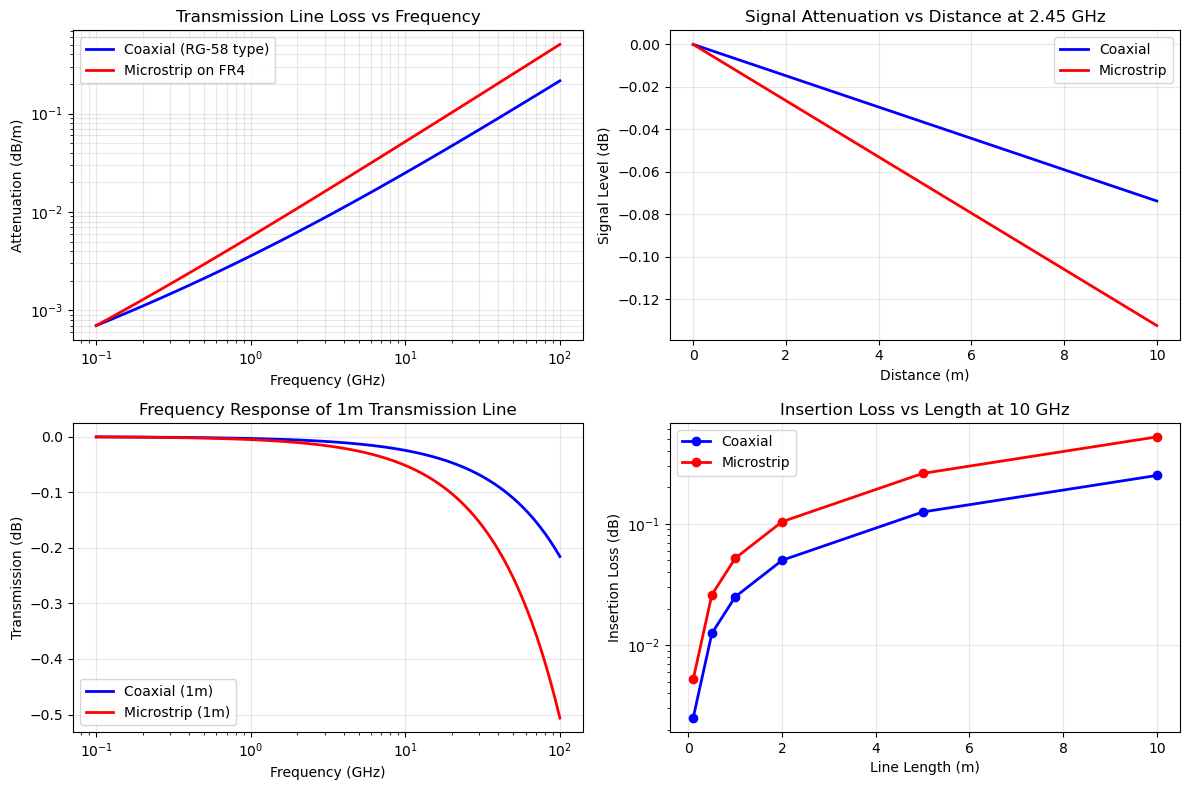

=== Transmission Line Loss Examples ===
At 2.45 GHz:
Coaxial cable loss: 0.007 dB/m
Microstrip loss:    0.013 dB/m

After 10m of line:
Coaxial signal level:  -0.1 dB (99.2% of input)
Microstrip signal level: -0.1 dB (98.5% of input)

At 10 GHz, 1m line:
Coaxial insertion loss:  0.02 dB
Microstrip insertion loss: 0.05 dB


In [5]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Lossy Transmission Line Parameters
# --------------------------
f_loss = np.logspace(8, 11, 100)  # 100 MHz to 100 GHz
Z0_lossy = 50.0                   # characteristic impedance
c = 3e8                           # speed of light
vp_lossy = 0.66 * c              # phase velocity

# Typical loss parameters for different transmission lines
# Loss in dB/m as a function of frequency

# Coaxial cable (RG-58 type) - conductor loss dominates at low freq
# α_coax ≈ k1*√f + k2*f (conductor + dielectric losses)
k1_coax = 0.05e-6    # conductor loss coefficient (dB/m/√Hz)
k2_coax = 2e-12      # dielectric loss coefficient (dB/m/Hz)
alpha_coax_db = k1_coax * np.sqrt(f_loss) + k2_coax * f_loss

# Microstrip on FR4 substrate - dielectric loss significant at high freq
k1_micro = 0.02e-6   # conductor loss coefficient
k2_micro = 5e-12     # dielectric loss coefficient (higher than coax)
alpha_micro_db = k1_micro * np.sqrt(f_loss) + k2_micro * f_loss

# Convert dB/m to Np/m (α in natural units)
alpha_coax_np = alpha_coax_db / 8.686  # 1 Np = 8.686 dB
alpha_micro_np = alpha_micro_db / 8.686

# --------------------------
# Signal Attenuation vs Distance
# --------------------------
distances = np.linspace(0, 10, 100)  # 0 to 10 meters
f_example = 2.45e9  # 2.45 GHz example frequency

# Calculate loss at example frequency
alpha_coax_2p45 = (k1_coax * np.sqrt(f_example) + k2_coax * f_example) / 8.686
alpha_micro_2p45 = (k1_micro * np.sqrt(f_example) + k2_micro * f_example) / 8.686

# Signal amplitude vs distance (normalized to input = 1)
signal_coax = np.exp(-alpha_coax_2p45 * distances)
signal_micro = np.exp(-alpha_micro_2p45 * distances)

# Convert to dB
signal_coax_db = 20 * np.log10(signal_coax)
signal_micro_db = 20 * np.log10(signal_micro)

# --------------------------
# Plot Loss vs Frequency
# --------------------------
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.loglog(f_loss/1e9, alpha_coax_db, 'b-', label='Coaxial (RG-58 type)', linewidth=2)
plt.loglog(f_loss/1e9, alpha_micro_db, 'r-', label='Microstrip on FR4', linewidth=2)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Attenuation (dB/m)')
plt.title('Transmission Line Loss vs Frequency')
plt.legend()
plt.grid(True, which="both", alpha=0.3)

# --------------------------
# Plot Signal vs Distance
# --------------------------
plt.subplot(2, 2, 2)
plt.plot(distances, signal_coax_db, 'b-', label='Coaxial', linewidth=2)
plt.plot(distances, signal_micro_db, 'r-', label='Microstrip', linewidth=2)
plt.xlabel('Distance (m)')
plt.ylabel('Signal Level (dB)')
plt.title(f'Signal Attenuation vs Distance at {f_example/1e9:.2f} GHz')
plt.legend()
plt.grid(True, alpha=0.3)

# --------------------------
# Frequency Response of a 1m Line
# --------------------------
line_length = 1.0  # 1 meter line
transfer_coax = np.exp(-alpha_coax_np * line_length)
transfer_micro = np.exp(-alpha_micro_np * line_length)

transfer_coax_db = 20 * np.log10(transfer_coax)
transfer_micro_db = 20 * np.log10(transfer_micro)

plt.subplot(2, 2, 3)
plt.semilogx(f_loss/1e9, transfer_coax_db, 'b-', label='Coaxial (1m)', linewidth=2)
plt.semilogx(f_loss/1e9, transfer_micro_db, 'r-', label='Microstrip (1m)', linewidth=2)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Transmission (dB)')
plt.title('Frequency Response of 1m Transmission Line')
plt.legend()
plt.grid(True, alpha=0.3)

# --------------------------
# Insertion Loss Comparison
# --------------------------
# Common lengths for different applications
lengths = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]  # meters
f_test = 10e9  # 10 GHz test frequency

alpha_coax_10g = (k1_coax * np.sqrt(f_test) + k2_coax * f_test) / 8.686
alpha_micro_10g = (k1_micro * np.sqrt(f_test) + k2_micro * f_test) / 8.686

loss_coax = alpha_coax_10g * np.array(lengths) * 8.686  # convert back to dB
loss_micro = alpha_micro_10g * np.array(lengths) * 8.686

plt.subplot(2, 2, 4)
plt.semilogy(lengths, loss_coax, 'bo-', label='Coaxial', linewidth=2, markersize=6)
plt.semilogy(lengths, loss_micro, 'ro-', label='Microstrip', linewidth=2, markersize=6)
plt.xlabel('Line Length (m)')
plt.ylabel('Insertion Loss (dB)')
plt.title(f'Insertion Loss vs Length at {f_test/1e9:.0f} GHz')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --------------------------
# Print some numerical examples
# --------------------------
print("=== Transmission Line Loss Examples ===")
print(f"At {f_example/1e9:.2f} GHz:")
print(f"Coaxial cable loss: {alpha_coax_2p45*8.686:.3f} dB/m")
print(f"Microstrip loss:    {alpha_micro_2p45*8.686:.3f} dB/m")
print(f"\nAfter 10m of line:")
print(f"Coaxial signal level:  {signal_coax_db[-1]:.1f} dB ({100*signal_coax[-1]:.1f}% of input)")
print(f"Microstrip signal level: {signal_micro_db[-1]:.1f} dB ({100*signal_micro[-1]:.1f}% of input)")

print(f"\nAt {f_test/1e9:.0f} GHz, 1m line:")
print(f"Coaxial insertion loss:  {loss_coax[2]:.2f} dB")
print(f"Microstrip insertion loss: {loss_micro[2]:.2f} dB")

### Transmission Line Loss Analysis Results

The four plots above demonstrate different aspects of transmission line losses:

#### **Plot 1: Loss vs Frequency**
- **Coaxial cables** have lower loss at lower frequencies due to better shielding
- **Microstrip lines** have higher dielectric losses, especially at higher frequencies
- Both show the characteristic √f behavior for conductor losses at low frequencies
- At high frequencies, dielectric losses (linear with f) dominate

#### **Plot 2: Signal Attenuation vs Distance**
- Shows exponential decay: $V(z) = V_0 e^{-\alpha z}$
- At 2.45 GHz, coaxial cable performs much better over long distances
- Critical for long cable runs in satellite, cable TV, and radar systems

#### **Plot 3: Frequency Response**
- Shows how a 1-meter line acts as a "lossy filter"
- Higher frequencies are attenuated more severely
- Important for broadband systems and high-speed digital signals

#### **Plot 4: Insertion Loss vs Length**
- Linear relationship between loss and length (in dB)
- Useful for link budget calculations
- Shows the trade-off between line length and signal integrity

### **Practical Implications:**
- **Short connections**: Microstrip acceptable for PCB traces
- **Long runs**: Coaxial cable preferred for low loss
- **High frequencies**: Special low-loss cables (LMR series) may be needed
- **System design**: Must account for losses in power budgets